In [1]:
!pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
from tensorflow import keras
tf.__version__

     |████████████████████████████████| 332.1MB 67kB/s 
     |████████████████████████████████| 419kB 49.5MB/s 
     |████████████████████████████████| 61kB 22.0MB/s 
     |████████████████████████████████| 3.0MB 51.1MB/s 


'2.0.0-alpha0'

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import re
%matplotlib inline

In [3]:
!wget https://raw.githubusercontent.com/ParakweetLabs/EmailIntentDataSet/master/src/resources/Ask0729-fixed.txt -O parakweet.txt

--2019-05-24 06:02:26--  https://raw.githubusercontent.com/ParakweetLabs/EmailIntentDataSet/master/src/resources/Ask0729-fixed.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347997 (340K) [text/plain]
Saving to: ‘parakweet.txt’

parakweet.txt       100%[===================>] 339.84K  --.-KB/s    in 0.003s  

2019-05-24 06:02:26 (129 MB/s) - ‘parakweet.txt’ saved [347997/347997]



In [0]:
data = pd.read_csv('parakweet.txt', header=None, delimiter='\t')
data.columns = ['label', 'content']
data['label'] = (data['label'] == 'Yes').astype(np.int)

In [5]:
data.head()

,label,content
0,0,>>> [1]Contact Me Now to Make $100 Today!$LINK
1,0,Act now to keep your life on the go!
2,0,Choose between $500 and $10000 dollars with up...
3,0,Click above to earn today.
4,0,Click here to receive your first $10 today:


In [0]:
data.loc[:, 'content'] = data.content.str.replace(r'\d+', '').str.translate(str.maketrans('', '', string.punctuation))

In [7]:
data.head()

,label,content
0,0,Contact Me Now to Make TodayLINK
1,0,Act now to keep your life on the go
2,0,Choose between and dollars with up to years...
3,0,Click above to earn today
4,0,Click here to receive your first today


In [0]:
data = data.sample(frac=1)

In [9]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
tokens = nltk.tokenize.word_tokenize(data.loc[:, 'content'].str.cat(sep=' '))

In [11]:
len(tokens)

59412

In [0]:
tokens = [w for w in tokens if w not in nltk.corpus.stopwords.words('english')]

In [13]:
len(tokens)

33953

In [0]:
frequency_dist = nltk.FreqDist(tokens)

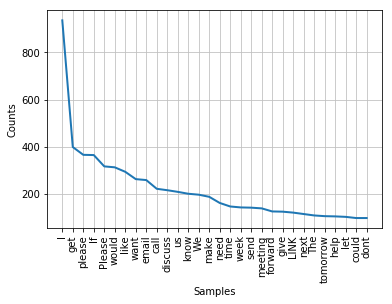

In [15]:
frequency_dist.plot(30, cumulative=False)

In [0]:
vocabs = list(set(tokens))

In [17]:
len(vocabs)

7465

In [0]:
from wordcloud import WordCloud

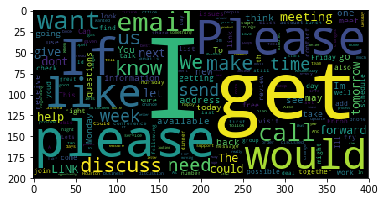

In [19]:
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.imshow(wordcloud)

In [0]:
def word_to_vec(word):
  tokens = nltk.tokenize.word_tokenize(word)
  tokens = [w for w in tokens if w not in nltk.corpus.stopwords.words('english')]
  word_vector = np.pad([vocabs.index(w) for w in tokens], (0, len(vocabs)-len(tokens)), 'constant', constant_values=0).astype(np.float)
  return word_vector.tolist()

In [0]:
X = np.vstack(data.loc[:, 'content'].apply(word_to_vec).values).astype(np.float32)

In [23]:
y = np.array(data.label, dtype='int32')
X.shape, y.shape

((3657, 7465), (3657,))

In [0]:
X_train, X_valid, X_test = X[:2000, :], X[2000:2500, :], X[2500:, :]
y_train, y_valid, y_test = y[:2000], y[2000:2500], y[2500:]

In [61]:
model = keras.Sequential([
    keras.layers.Embedding(len(vocabs), 64),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

W0524 06:37:29.295680 140430238406528 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fb78e0b5240>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0524 06:37:29.301044 140430238406528 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fb78e0b5748>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          477760    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 552,129
Trainable params: 552,129
Non-trainable params: 0
_________________________________________________________________


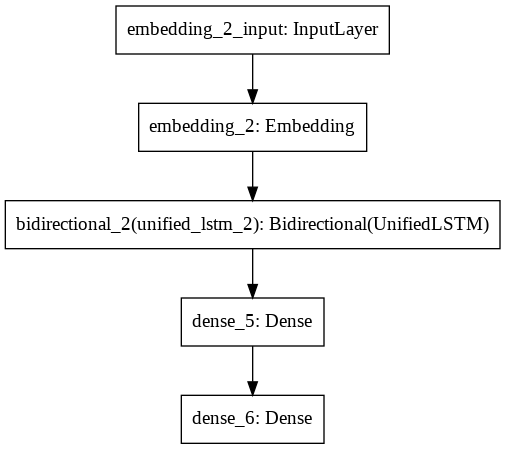

In [43]:
keras.utils.plot_model(model)

In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [63]:
history = model.fit(X_train, y_train, epochs=3, validation_data=[X_valid, y_valid], callbacks=[early_stop])

Train on 2000 samples, validate on 500 samples
Epoch 1/3
2000/2000 [==============================] - 35s 17ms/sample - loss: 0.6505 - accuracy: 0.6410 - val_loss: 0.5357 - val_accuracy: 0.7540
Epoch 2/3
2000/2000 [==============================] - 35s 17ms/sample - loss: 0.3360 - accuracy: 0.8595 - val_loss: 0.5117 - val_accuracy: 0.7700
Epoch 3/3
2000/2000 [==============================] - 35s 17ms/sample - loss: 0.1335 - accuracy: 0.9530 - val_loss: 0.7478 - val_accuracy: 0.7380


In [64]:
model.evaluate(X_test, y_test)

1157/1157 [==============================] - 9s 7ms/sample - loss: 0.7202 - accuracy: 0.7597


[0.7202137273864284, 0.7597234]

In [65]:
text1 = 'Where are the files? Please send fast.'
text2 = 'You have won an item.'
text1 = text1.replace(r'\d+', '').translate(str.maketrans('', '', string.punctuation))
text2 = text2.replace(r'\d+', '').translate(str.maketrans('', '', string.punctuation))

text_vec = []
for text in (text1, text2):
  vec = word_to_vec(text)
  text_vec.append(vec)
text_vec = np.array(text_vec, dtype=np.float)
text_vec = np.vstack(text_vec).astype(np.float)
model.predict(text_vec)

[[ 240. 2185.  837. ...    0.    0.    0.]
 [2729. 2519.    0. ...    0.    0.    0.]]


array([[0.9769654 ],
       [0.04046804]], dtype=float32)